# Homework, Week 14, Heather Leighton-Dick

In [1]:
#everything and the kitchen sink
import numpy as np
import pandas as pd
import math
import statistics
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson
import time
import warnings
warnings.filterwarnings('ignore')
from itertools import product

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from statsmodels.formula.api import logit
from statsmodels.formula.api import ols
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, recall_score, precision_score

## 1.	Perform pre-processing on the full dataset here: https://www.kaggle.com/sohier/calcofi 

In [2]:
#Import to dataframe
bottle_file = pd.read_csv("bottle.csv")
bottle_df = pd.DataFrame(bottle_file)

cast_file = pd.read_csv("cast.csv")
cast_df = pd.DataFrame(cast_file)

#"IncTim" column records incubation time; they are time stamps
bottle_df["IncTim"].value_counts().sum()
bottle_df["IncTim"] = bottle_df["IncTim"].astype("datetime64")

#Columns 67-73 have 2000 or fewer values (in comparison to dataset as whole >800,000 rows)
bottle_df.drop(bottle_df.columns[[67,73]], axis=1)

# Drop rows with "bad" data found via Quality Codes but it cut the dataset in half.
# RecInd = 3 when data is observed; when T_qual and S_qual are equal to "9", the data is missing
bottle_df = bottle_df[bottle_df["RecInd"] == 3]
bottle_df = bottle_df[bottle_df["T_qual"] != 9]
bottle_df = bottle_df[bottle_df["S_qual"] != 9]

#drop columns with Quality Codes because they describe the quality of samples taken 
#and won't be correlated with variables regarding chemical composition (white noise)
bottle_df = bottle_df.drop(columns=["T_qual", "T_prec", "S_qual", "S_prec", "P_qual", "O_qual", "O2Satq", "Chlqua", "Phaqua", "PO4q", "SiO3qu", "NO2q", "NO3q", "NH3q", "C14A1p", "C14A1q", "C14A2p", "C14A2q", "DarkAp", "DarkAq", "MeanAp", "MeanAq"], axis=1)

#drop RecInd, R_Depth, R_TEMP, R_SALINITY rows (R_TEMP and R_SALINITY are duplicates of T_degC and Salnty respectively)
bottle_df = bottle_df.drop(columns=["R_Depth","RecInd", "R_TEMP", "R_SALINITY"], axis=1)

#keep columns which may impact data correlation
cast_subset_df = cast_df[["Cst_Cnt", "Quarter", "Month", "Year", "Lat_Deg", "Lon_Deg", "Bottom_D", "Wave_Dir", "Dry_T", "Wet_T" ]]
#cast_subset_df.info()

#join on Cst_Cnt
jn_bot_cast_df = bottle_df.join(cast_subset_df, on="Cst_Cnt", lsuffix="_b", rsuffix="c")

#fill null values in T_degC and Salnty columns
T_degC_mean = jn_bot_cast_df["T_degC"].mean()
Salnty_mean = jn_bot_cast_df["Salnty"].mean()
jn_bot_cast_df["T_degC"] = jn_bot_cast_df["T_degC"].fillna(T_degC_mean)
jn_bot_cast_df["Salnty"] = jn_bot_cast_df["Salnty"].fillna(Salnty_mean)

#check result
jn_bot_cast_df.head()

,Cst_Cnt_b,Btl_Cnt,Sta_ID,Depth_ID,Depthm,T_degC,Salnty,O2ml_L,STheta,O2Sat,...,Cst_Cntc,Quarter,Month,Year,Lat_Deg,Lon_Deg,Bottom_D,Wave_Dir,Dry_T,Wet_T
0,1,1,054.0 056.0,19-4903CR-HY-060-0930-05400560-0000A-3,0,10.50,33.44,NaN,25.649,NaN,...,2.0,1.0,3.0,1949.0,38.0,-125.0,NaN,NaN,NaN,NaN
1,1,2,054.0 056.0,19-4903CR-HY-060-0930-05400560-0008A-3,8,10.46,33.44,NaN,25.656,NaN,...,2.0,1.0,3.0,1949.0,38.0,-125.0,NaN,NaN,NaN,NaN
3,1,4,054.0 056.0,19-4903CR-HY-060-0930-05400560-0019A-3,19,10.45,33.42,NaN,25.643,NaN,...,2.0,1.0,3.0,1949.0,38.0,-125.0,NaN,NaN,NaN,NaN
6,1,7,054.0 056.0,19-4903CR-HY-060-0930-05400560-0039A-3,39,10.45,33.44,NaN,25.658,NaN,...,2.0,1.0,3.0,1949.0,38.0,-125.0,NaN,NaN,NaN,NaN
8,1,9,054.0 056.0,19-4903CR-HY-060-0930-05400560-0058A-3,58,10.06,33.42,NaN,25.710,NaN,...,2.0,1.0,3.0,1949.0,38.0,-125.0,NaN,NaN,NaN,NaN


## 2.	Perform feature selection (decide what columns should be included in your analysis). How did you figure out what features were important?

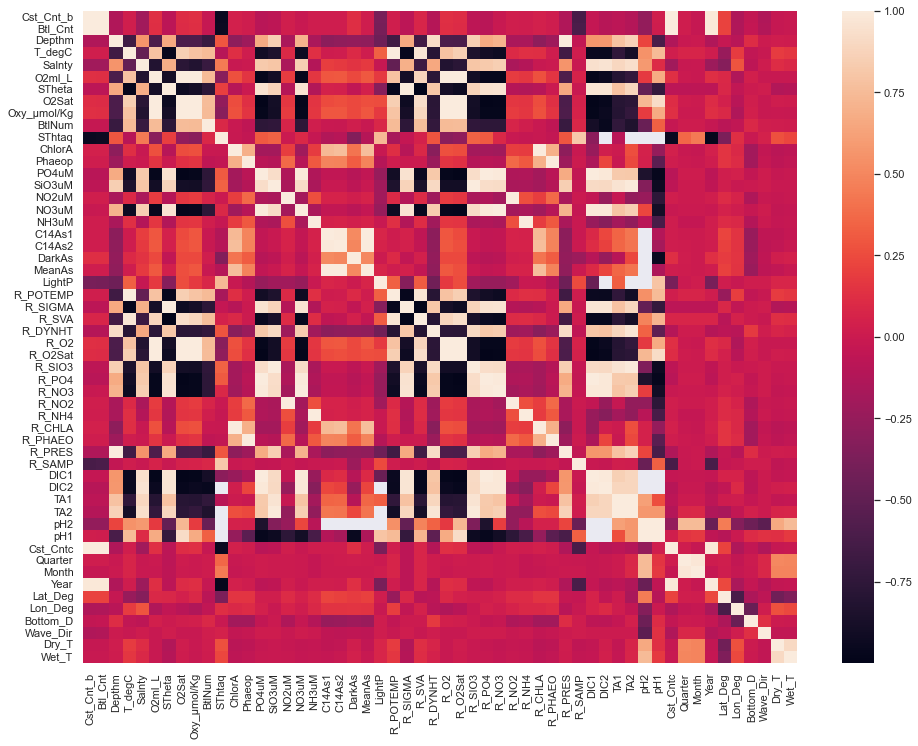

In [3]:
#correlation matrix table
corr_bot_cast_df=jn_bot_cast_df.corr()
#correlation matrix heat map
sns.set(rc = {'figure.figsize':(16,12)})
heat_bot_cast_df = sns.heatmap(corr_bot_cast_df)
plt.show()

### Choosing Variables:
Using the findings from Week 13 Homework's Heatmap, I looked along the T_degC line from left to right for either very light (positive correlation) or very dark colors (negative correlation). T_degC (water temperature) is positively correlated with Oxy_µmol/kg (oxygen in micro moles per kilogram of seawater) and negatively correlated with Depthm (depth in meters), R_PO4 (reported phosphate concentration), and SiO3uM (silicate concentration).

So, I will treat T_degC as the response (y) variable, and SiO3uM and Depthm as the explanatory (x) variables.

## 3.	Perform multiple linear regression on the dataset. Be sure to display the final resulting equation with the coefficients and intercept in markdown. 

In [4]:
#a bit more preprocessing -- remove the symbol for mole and the slash from the column name
#jn_bot_cast_df["Oxy_mmolkg"] = jn_bot_cast_df["Oxy_µmol/Kg"]

#finding min and max values to set the np.arange parameters
#print("Oxy_mmolkg min: " + str(jn_bot_cast_df["Oxy_mmolkg"].min()))
#print("Oxy_mmolkg max: " + str(jn_bot_cast_df["Oxy_mmolkg"].max()))

print("Depthm min: " + str(jn_bot_cast_df["Depthm"].min()))
print("Depthm max: " + str(jn_bot_cast_df["Depthm"].max()))

print("SiO3uM min: " + str(jn_bot_cast_df["SiO3uM"].min()))
print("SiO3uM min: " + str(jn_bot_cast_df["SiO3uM"].max()))

Depthm min: 0
Depthm max: 5351
SiO3uM min: 0.0
SiO3uM min: 196.0


In [5]:
#multiple linear regression
jn_bot_cast_df_mdl = ols("T_degC ~ Depthm + SiO3uM", data=jn_bot_cast_df).fit()
coeffs = jn_bot_cast_df_mdl.params
print(coeffs)

Intercept    14.371624
Depthm        0.003349
SiO3uM       -0.143243
dtype: float64


In [6]:
#setting up the variables
#Oxy_mmolkg = np.arange(0,1,0.0001)
Depthm = np.arange(0, 5355, 50)
SiO3uM = np.arange(0, 200, 20)

T_degC = jn_bot_cast_df["T_degC"].unique()

#prediction flow
p = product(Depthm, SiO3uM, T_degC)

explanatory_data = pd.DataFrame(p, columns=["Depthm", "SiO3uM", "T_degC"])

prediction_data = explanatory_data.assign(T_degC = jn_bot_cast_df_mdl.predict(explanatory_data))

## 4.	Which regression approach had the “best” performance? Be sure to compare it to what you did last week.

In [7]:
print("R-squared: " + str(jn_bot_cast_df_mdl.rsquared))
print("RSE: " + str(np.sqrt(jn_bot_cast_df_mdl.mse_resid)))

R-squared: 0.720329562812045
RSE: 2.006243780480359


### Comparison with last week's results:

A direct comparison is not exactly possible, since I chose to look at the water temperature's relationship with depth (in meters) and silicate concentration. 

However, this model's r-squared value of 0.72 indicates a stronger positive correlation among water temperature, depth, and silicate concentration, which is much stronger than last week's relationship of 0.24 between water temperature and salinity.

The RSE value (about 2.0) of this week's model is much lower than last week's RMSE of 3.68; generally, the lower the number, the less distance there is between the prediction line and the actual data points.

In conclusion, this week's multiple linear regression model seems to work a little better than last week's single-variable linear regression.

## 5.	Work with the diabetes dataset to perform multiple logistic regression.

In [2]:
diabetes_df = pd.read_csv("diabetes.csv")
diabetes_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Optimization terminated successfully.
         Current function value: 0.502215
         Iterations 6


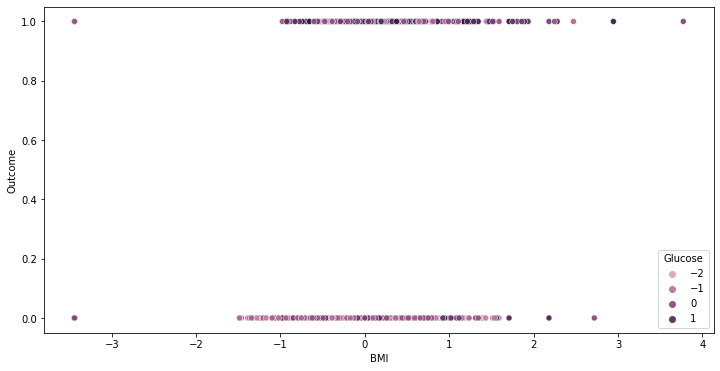

In [27]:
#Multiple Logistic Regression
diabetes_mdl = logit("Outcome ~ BMI + Glucose", data=diabetes_df).fit()

#Prediction Flow
BMI = np.arange(0,68,4)
Glucose = np.arange(0,200,4)

p = product(BMI, Glucose)

explanatory_data = pd.DataFrame(p, columns=["BMI", "Glucose"])

prediction_data = explanatory_data.assign(Outcome = diabetes_mdl.predict(explanatory_data))

prediction_data["most_likely_outcome"] = np.round(prediction_data["Outcome"])

plt.figure(figsize=(12,6))
sns.scatterplot(x="BMI", y="Outcome", data=diabetes_df, hue="Glucose")
plt.show()

<AxesSubplot:xlabel='BMI', ylabel='Glucose'>

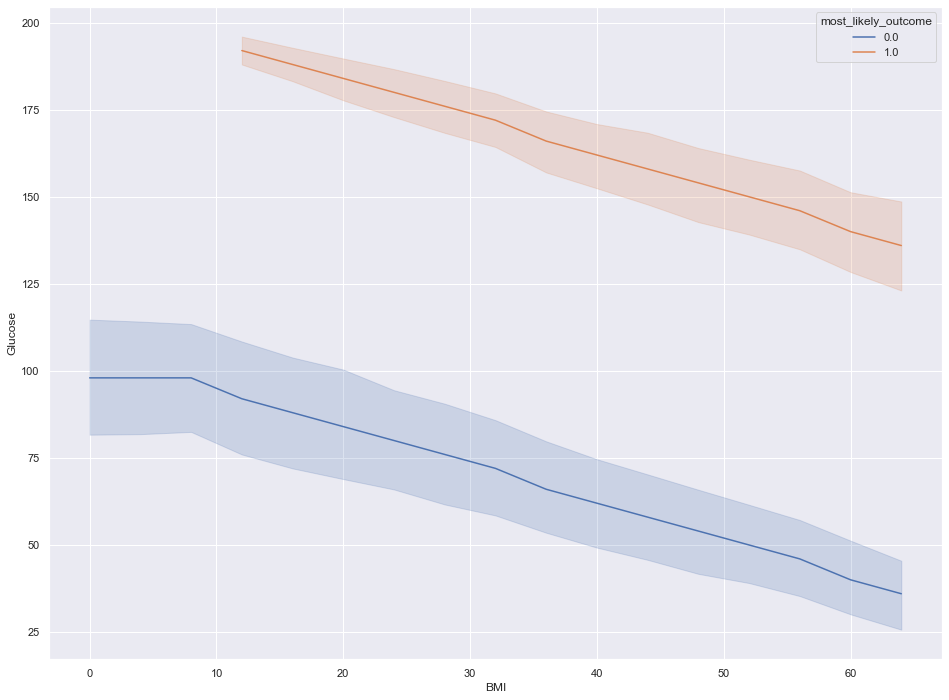

In [10]:
sns.lineplot(x="BMI", y="Glucose", data=prediction_data, hue="most_likely_outcome")

In [11]:
#Confusion Matrix
diabetes_conf_matrix = diabetes_mdl.pred_table()
print(diabetes_conf_matrix)

[[445.  55.]
 [126. 142.]]


In [12]:
#find accuracy of model
tn = 445
fp = 55
fn = 126
tp = 142

accuracy = (tp + tn)/(tn+fp+fn+tp)

print("Accuracy: " + str(accuracy))

Accuracy: 0.7643229166666666


## 6.	What are the other ways to assess the performance of the model besides accuracy? 

In [13]:
#Other scores for the model
precision = (tp)/(tp+fp)
recall = tp/(tp+fn)
F1_score = (2*precision*recall)/(precision+recall)

print("Precision: " + str(precision))
print("Recall: " + str(recall))
print("F1 Score: " + str(F1_score))

Precision: 0.7208121827411168
Recall: 0.5298507462686567
F1 Score: 0.610752688172043


## What approach makes the most sense with the diabetes dataset? Why?

Other ways to assess the performance of the model are its precision, recall, and F1 score. The model's best score is its accuracy at 76%, while precision comes in a close second at 72%. In a medical setting, it seems better to give a false positive diagnosis to a patient who then might make positive lifestyle changes as a result of the diagnosis, than to give a false negative diagnosis and potentially ignore a patient's life-threatening symptoms. Therefore, I think precision is a better approach in this situation than recall, which factors in false negatives.

## 7.	Tune your model to improve performance based on the performance metric you identified in question 6. Look at the documentation for logistic regression in statsmodel and/or sklearn and see if you can tune the model performance based on available parameters.

I decided to try preprocessing with RobustScaler so BMI and Glucose are on similar footing in the dataset and outliers are less weighted. However, the results gave me negative BMI numbers, which is not physically possible for the human body.

In [14]:
scaler = RobustScaler()
RS = RobustScaler().fit(diabetes_df)
print(RS)

RobustScaler()


In [15]:
diabetes_df[["BMI", "Glucose"]] = RS.fit_transform(diabetes_df[["BMI", "Glucose"]])
print(diabetes_df.head())

   Pregnancies   Glucose  BloodPressure  SkinThickness  Insulin       BMI  \
0            6  0.751515             72             35        0  0.172043   
1            1 -0.775758             66             29        0 -0.580645   
2            8  1.600000             64              0        0 -0.935484   
3            1 -0.678788             66             23       94 -0.419355   
4            0  0.484848             40             35      168  1.193548   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [20]:
#Multiple Logistic Regression
diabetes_mdl_rs = logit("Outcome ~ BMI + Glucose +0", data=diabetes_df).fit()

#print coeffs
print(diabetes_mdl_rs.params)

Optimization terminated successfully.
         Current function value: 0.579075
         Iterations 6
BMI        0.614560
Glucose    1.183625
dtype: float64


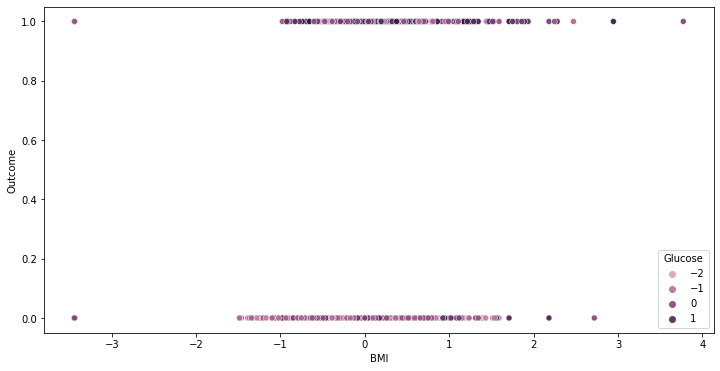

In [21]:
#Prediction Flow
BMI = np.arange(0,68,4)
Glucose = np.arange(0,200,4)

p = product(BMI, Glucose)

explanatory_data_rs = pd.DataFrame(p, columns=["BMI", "Glucose"])

prediction_data_rs = explanatory_data_rs.assign(Outcome = diabetes_mdl_rs.predict(explanatory_data_rs))

prediction_data_rs["most_likely_outcome"] = np.round(prediction_data_rs["Outcome"])

plt.figure(figsize=(12,6))
sns.scatterplot(x="BMI", y="Outcome", data=diabetes_df, hue="Glucose")
plt.show()


In [23]:
#Confusion Matrix
diabetes_conf_matrix = diabetes_mdl_rs.pred_table()
print(diabetes_conf_matrix)

[[322. 178.]
 [ 56. 212.]]


In [25]:
#previous confusion matrix
#[[445.  55.]
# [126. 142.]]


#find accuracy of model
tn = 332
fp = 178
fn = 56
tp = 212

accuracy = (tp + tn)/(tn+fp+fn+tp)

print("Accuracy: " + str(accuracy))

Accuracy: 0.699228791773779


In [26]:
#Other scores for the model
precision = (tp)/(tp+fp)
recall = tp/(tp+fn)
F1_score = (2*precision*recall)/(precision+recall)

print("Precision: " + str(precision))
print("Recall: " + str(recall))
print("F1 Score: " + str(F1_score))

Precision: 0.5435897435897435
Recall: 0.7910447761194029
F1 Score: 0.6443768996960486


### Conclusions about using RobustScaler on the diabetes dataset:
RobustScaler was not a good choice for rescaling the data. For one thing, the BMI was rescaled to include negative numbers, which isn't physically possible. If that was not enough, accuracy went from 0.76 to 0.70, precision went from 0.72 to 0.54, and the number of false positives went way up from 55 to 178.

## 8.	Is the KNN model or the multiple logistic regression model more performant for the diabetes dataset? How can you tell?

The KNN model's top accuracy score was about 0.76 for a K of 38, while my multiple logistic regression model topped out at an acccuracy of 0.76. So, there wasn't much difference between the two, and neither model was more performant overall. I might be able to improve the logistic model by applying intercept-scaling, increasing penalties; I also came across the RandomForestClassifier, which sounded intriguing but I ran out of time to look into it.

## Intermediate Multiple Linear Regression Datacamp certificate

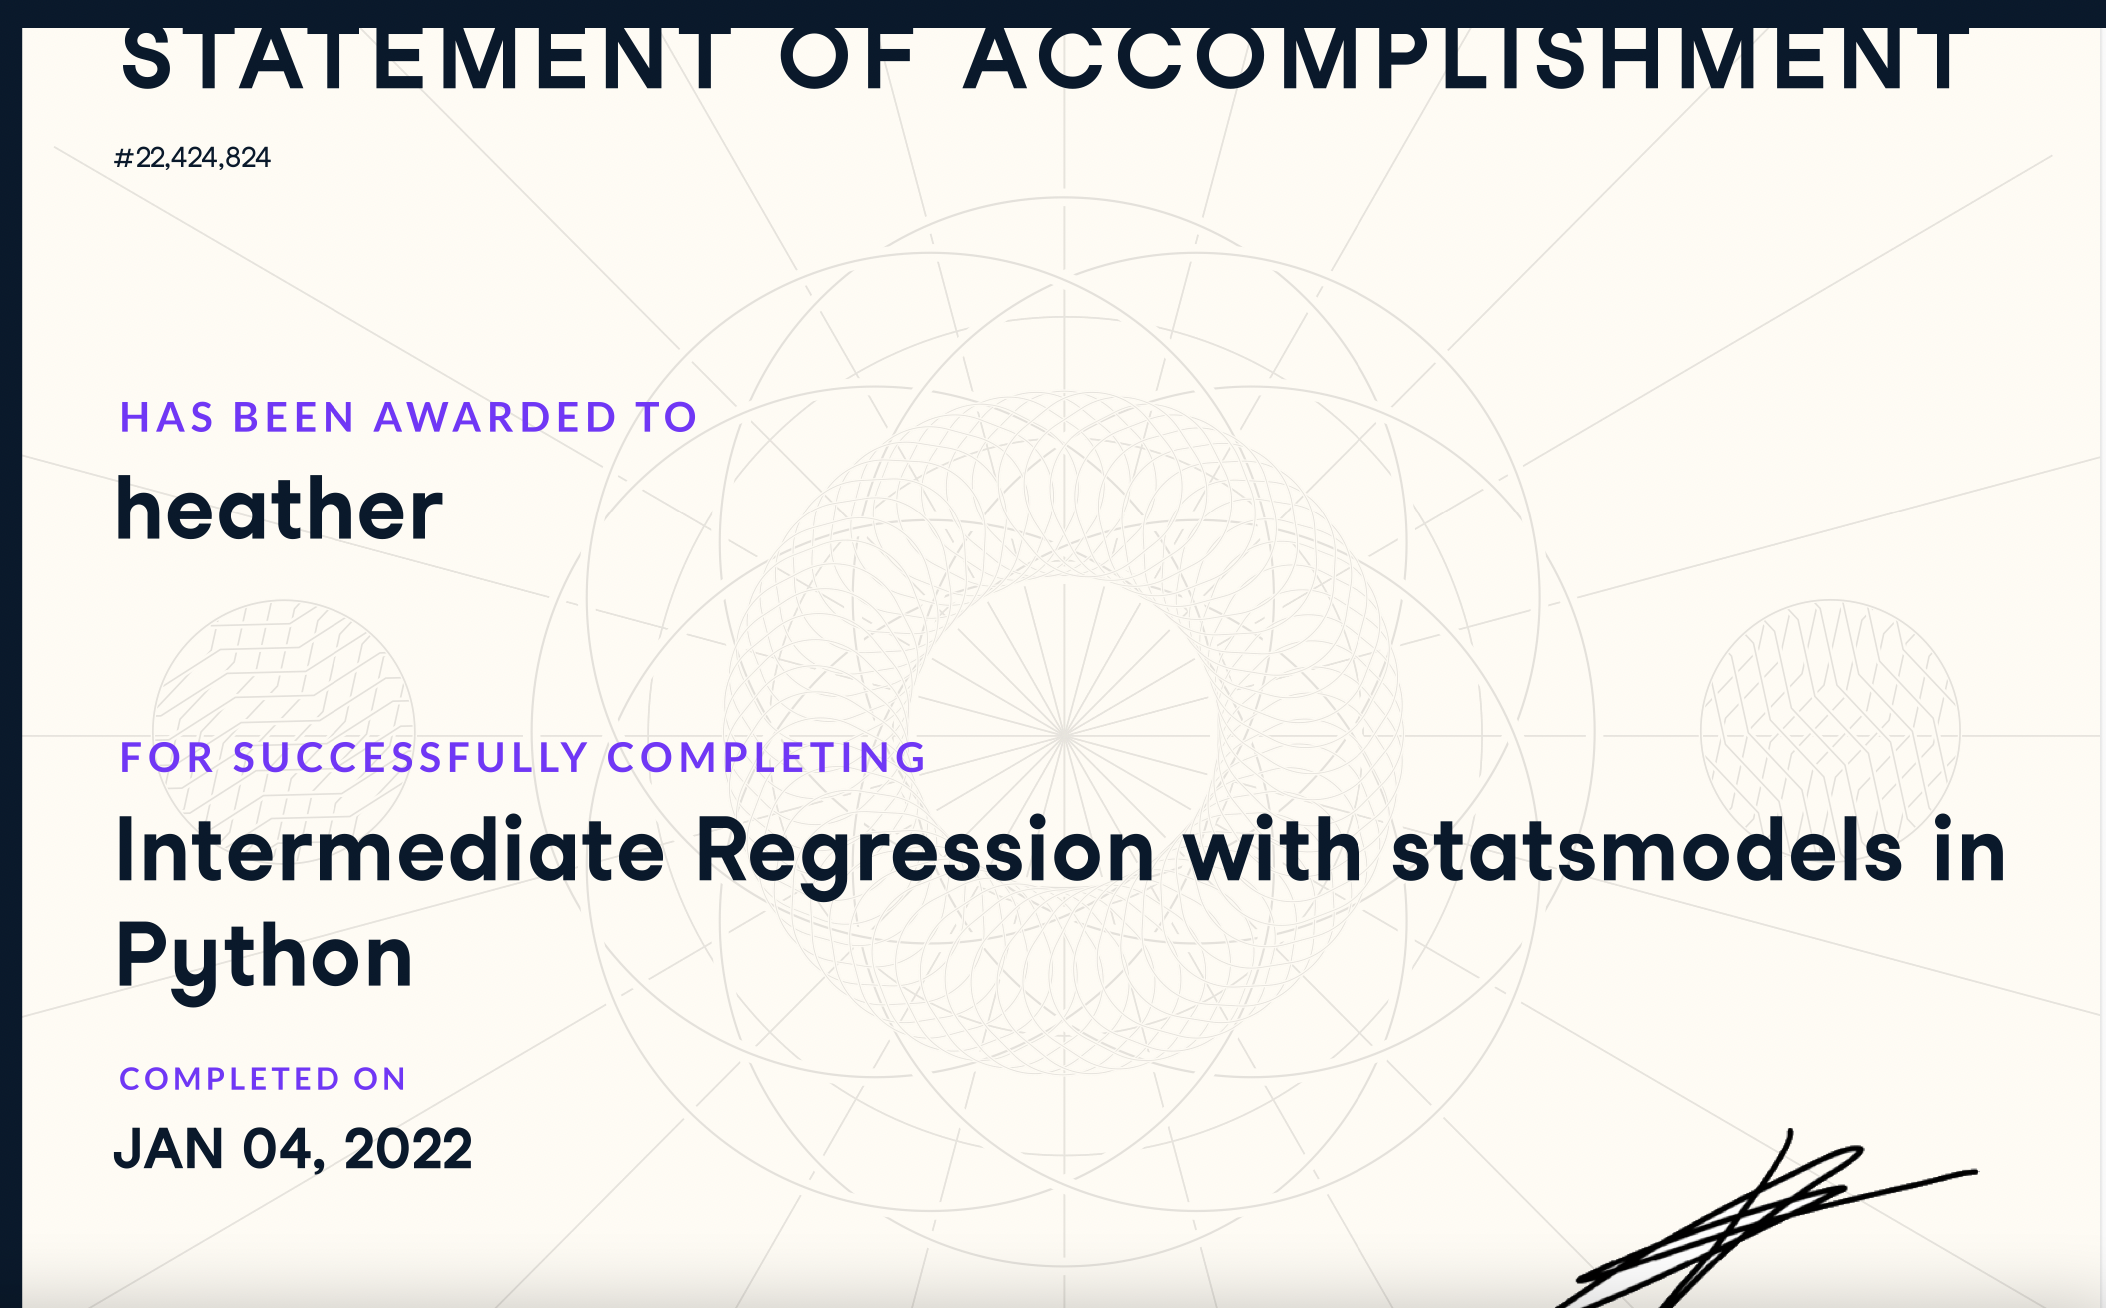